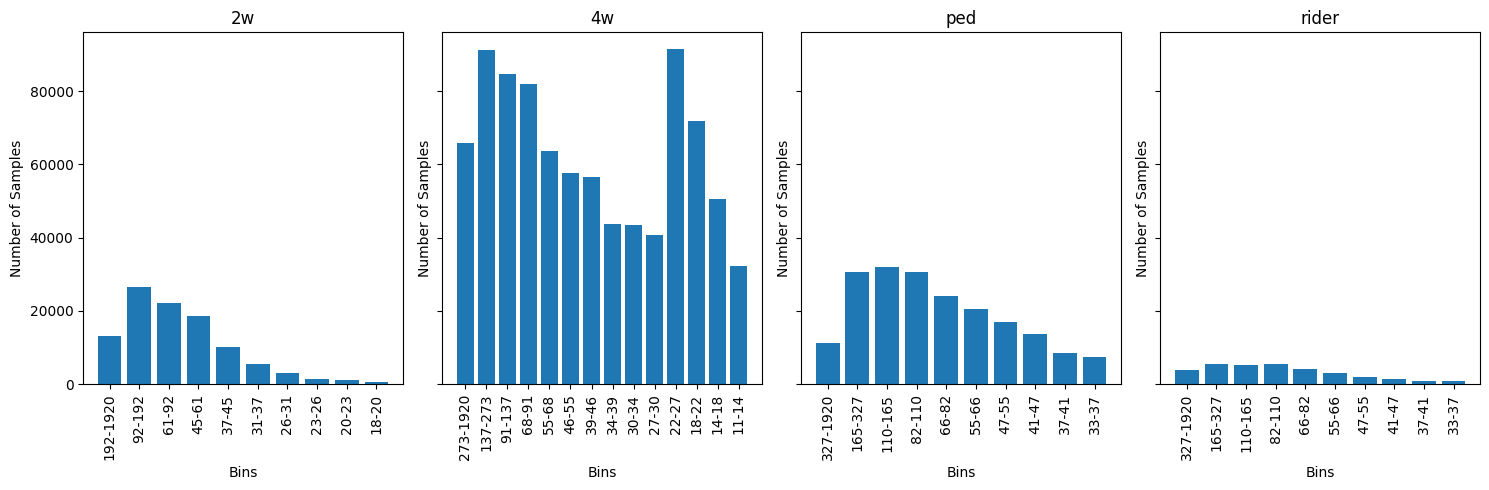

In [3]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from thresholds import thresholds

dataset_path = '/home/b2b/arthur/data/all_data_coco.json'

# Load the COCO dataset
with open(dataset_path, 'r') as f:
    coco_data = json.load(f)

# Create a DataFrame for the annotations
annotations = pd.DataFrame(coco_data['annotations'])

# Create a dictionary to store counts for each class and each bin
class_bin_counts = {class_name: [0] * len(thresholds[class_name]['bins']) for class_name in thresholds.keys()}

# Iterate over annotations to count the samples for each class and each bin based on height
for _, annotation in annotations.iterrows():
    category_id = annotation['category_id']
    bbox_height = annotation['bbox'][3]  # bbox format is [top-left-x, top-left-y, width, height]
    
    # Map category_id to class name
    class_name = coco_data['categories'][category_id]['name']
    
    # Determine the bin for the current bounding box height
    for bin_idx, (min_height, max_height) in enumerate(thresholds[class_name]['bins']):
        if min_height <= bbox_height < max_height:
            class_bin_counts[class_name][bin_idx] += 1
            break

# Plot the results
fig, axes = plt.subplots(1, len(class_bin_counts), figsize=(15, 5), sharey=True)

for ax, (class_name, bin_counts) in zip(axes, class_bin_counts.items()):
    ax.bar(range(len(bin_counts)), bin_counts)
    ax.set_title(class_name)
    ax.set_xlabel('Bins')
    ax.set_xticks(range(len(bin_counts)))
    ax.set_xticklabels([f"{min_height}-{max_height}" for min_height, max_height in thresholds[class_name]['bins']], rotation=90)
    ax.set_ylabel('Number of Samples')

plt.tight_layout()
plt.show()


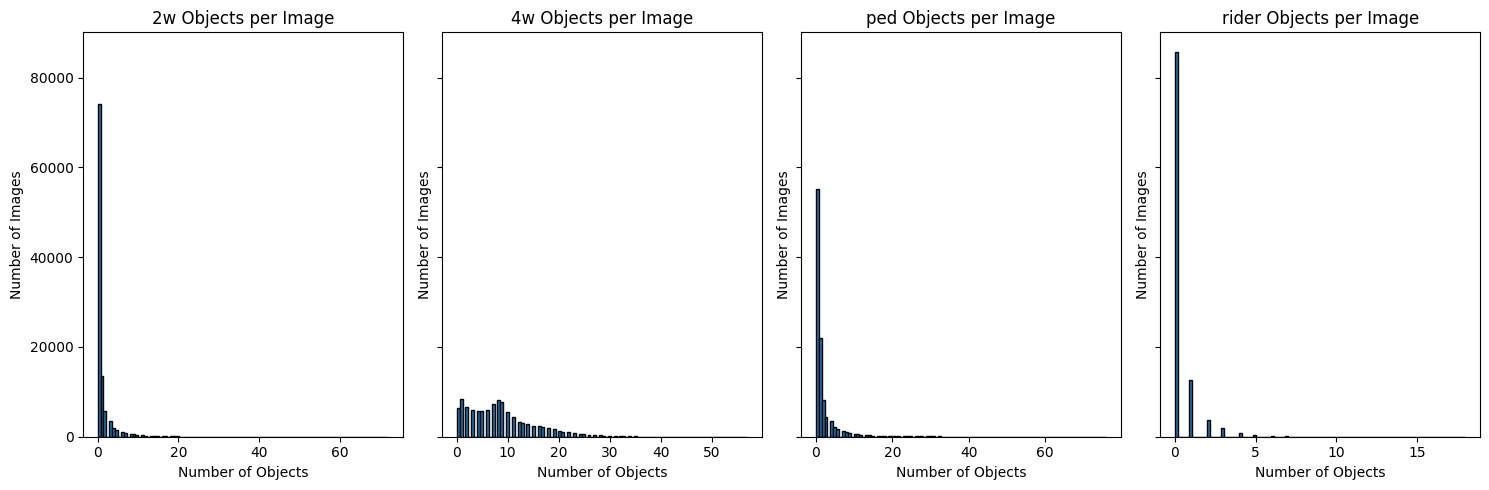

In [6]:
'''objects_per_image = {class_name: [] for class_name in thresholds.keys()}

# Iterate over the images
for image in coco_data['images']:
    image_id = image['id']
    
    # Filter annotations for the current image
    image_annotations = annotations[annotations['image_id'] == image_id]
    
    # Count objects per class in the current image
    for class_name in thresholds.keys():
        category_id = next((cat['id'] for cat in coco_data['categories'] if cat['name'] == class_name), None)
        count = len(image_annotations[image_annotations['category_id'] == category_id])
        objects_per_image[class_name].append(count)'''

# Plot the histograms
fig, axes = plt.subplots(1, len(objects_per_image), figsize=(15, 5), sharey=True)

for ax, (class_name, counts) in zip(axes, objects_per_image.items()):
    ax.hist(counts, bins=100, edgecolor='black')
    ax.set_title(f"{class_name} Objects per Image")
    ax.set_xlabel('Number of Objects')
    ax.set_ylabel('Number of Images')

plt.tight_layout()
plt.show()

In [8]:
# Initialize a dictionary to store counts of images without objects for each class
no_objects_count = {class_name: 0 for class_name in thresholds.keys()}

# Counter for images without any objects
no_objects_in_image_count = 0

# Iterate over the images
for image in coco_data['images']:
    image_id = image['id']
    
    # Filter annotations for the current image
    image_annotations = annotations[annotations['image_id'] == image_id]
    
    # Check if there are any objects of each class in the current image
    has_any_objects = False
    for class_name in thresholds.keys():
        category_id = next((cat['id'] for cat in coco_data['categories'] if cat['name'] == class_name), None)
        has_objects = len(image_annotations[image_annotations['category_id'] == category_id]) > 0
        
        # Count images without objects of the current class
        if not has_objects:
            no_objects_count[class_name] += 1
        else:
            has_any_objects = True
    
    # Count images without any objects
    if not has_any_objects:
        no_objects_in_image_count += 1

# Calculate and print percentages for each class
total_images = len(coco_data['images'])
for class_name, count in no_objects_count.items():
    percentage = (count / total_images) * 100
    print(f"Percentage of images without {class_name}: {percentage:.2f}%")

# Calculate and print the percentage of images without any objects
no_objects_percentage = (no_objects_in_image_count / total_images) * 100
print(f"Percentage of images without any objects: {no_objects_percentage:.2f}%")


Percentage of images without 2w: 70.12%
Percentage of images without 4w: 6.12%
Percentage of images without ped: 52.25%
Percentage of images without rider: 81.08%
Percentage of images without any objects: 2.31%


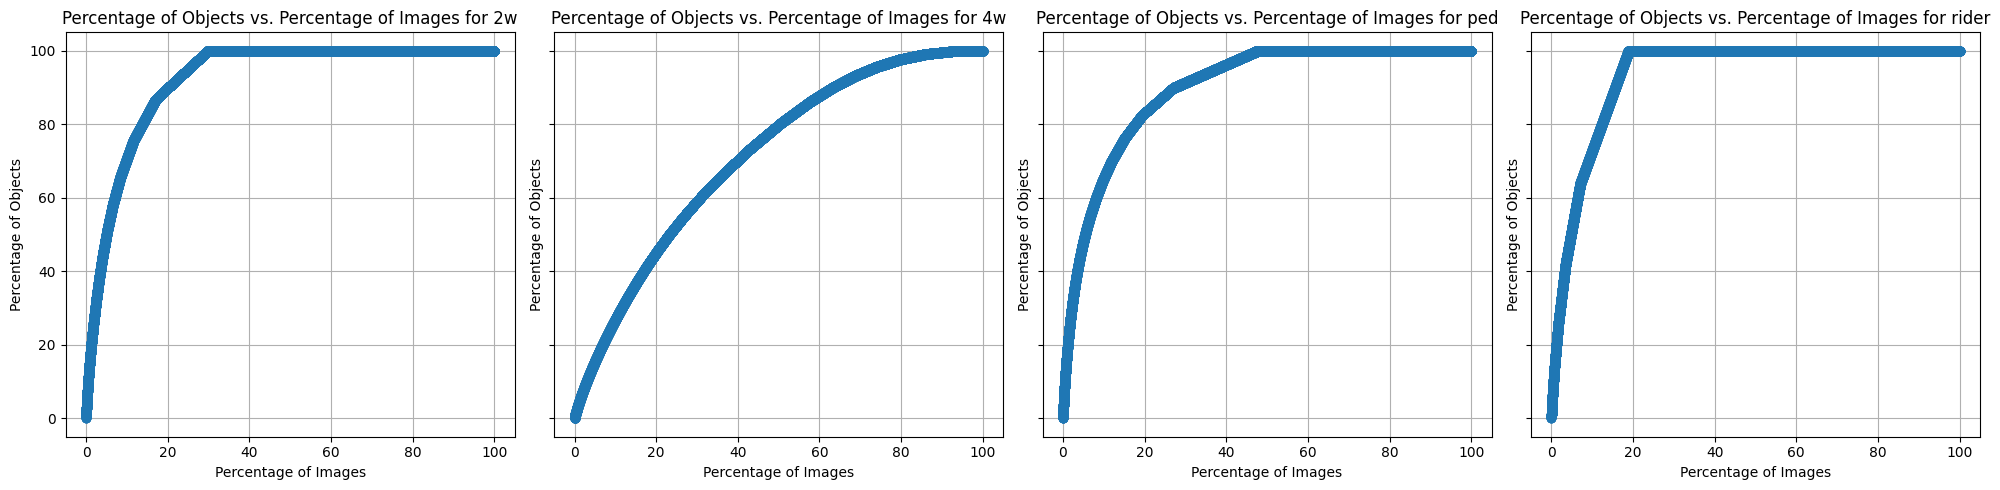

In [10]:
# Initialize a dictionary to store total objects per image for each class
total_objects_per_image_per_class = {class_name: [] for class_name in thresholds.keys()}

# Calculate the total number of objects per image for each class
for image in coco_data['images']:
    image_id = image['id']
    image_annotations = annotations[annotations['image_id'] == image_id]
    
    for class_name in thresholds.keys():
        category_id = next((cat['id'] for cat in coco_data['categories'] if cat['name'] == class_name), None)
        count = len(image_annotations[image_annotations['category_id'] == category_id])
        total_objects_per_image_per_class[class_name].append(count)

# Plot the percentage of objects vs. percentage of images for each class
fig, axes = plt.subplots(1, len(total_objects_per_image_per_class), figsize=(20, 5), sharey=True)

for ax, (class_name, total_objects_per_image) in zip(axes, total_objects_per_image_per_class.items()):
    # Sort the images by the number of objects (descending order)
    sorted_objects_per_image = sorted(total_objects_per_image, reverse=True)
    
    # Compute cumulative sums for objects and images
    cumulative_objects = np.cumsum(sorted_objects_per_image)
    cumulative_images = np.arange(1, len(sorted_objects_per_image) + 1)
    
    # Convert to percentages
    total_objects = cumulative_objects[-1] if cumulative_objects[-1] > 0 else 1  # Avoid division by zero
    total_images = cumulative_images[-1]
    percent_objects = cumulative_objects / total_objects * 100
    percent_images = cumulative_images / total_images * 100
    
    # Plot the percent of objects vs. percent of images
    ax.plot(percent_images, percent_objects, marker='o')
    ax.set_title(f"Percentage of Objects vs. Percentage of Images for {class_name}")
    ax.set_xlabel("Percentage of Images")
    ax.set_ylabel("Percentage of Objects")
    ax.grid(True)

plt.tight_layout()
plt.show()


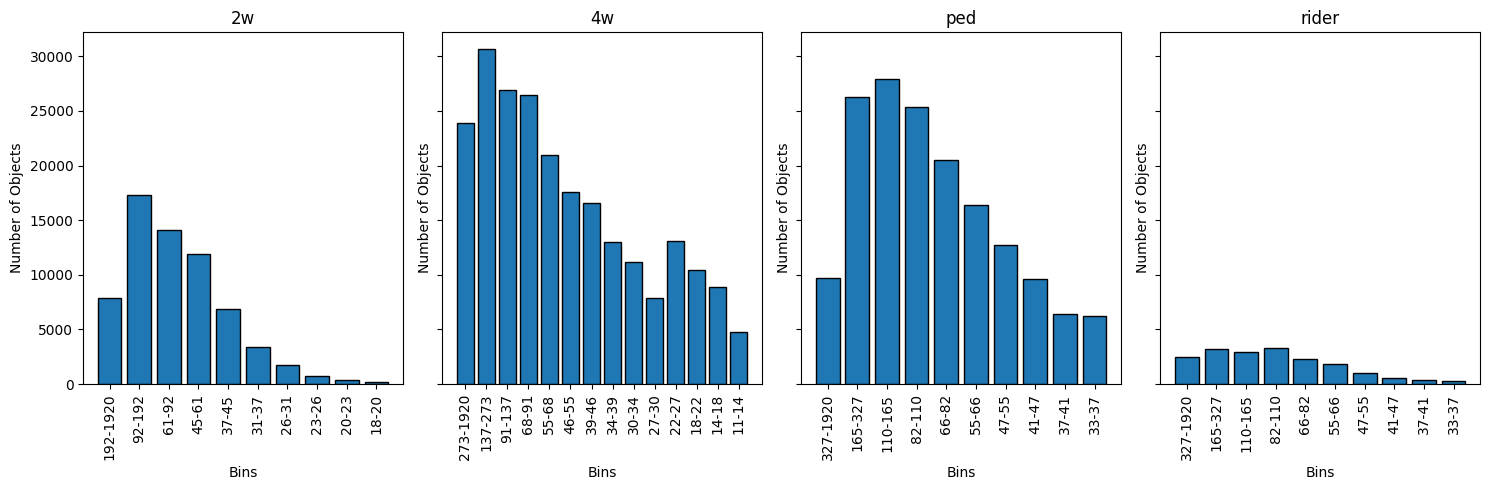

In [22]:
# Step 1: Calculate the number of pedestrians in each image
'''pedestrian_counts = []
image_ids = []

for image in coco_data['images']:
    image_id = image['id']
    image_annotations = annotations[annotations['image_id'] == image_id]
    
    # Get the category ID for pedestrians
    ped_category_id = next((cat['id'] for cat in coco_data['categories'] if cat['name'] == 'ped'), None)
    
    # Count the number of pedestrians in the image
    ped_count = len(image_annotations[image_annotations['category_id'] == ped_category_id])
    
    pedestrian_counts.append(ped_count)
    image_ids.append(image_id)

# Step 2: Sort the images by the number of pedestrians and select the top 20%
sorted_indices = np.argsort(pedestrian_counts)[::-1]  # Sort descending
top_20_percent_index = int(len(sorted_indices) * 0.2)
selected_image_ids = [image_ids[i] for i in sorted_indices[:top_20_percent_index]]

# Step 3: Calculate the bin distribution for all classes in the selected images
objects_per_image = {class_name: [] for class_name in thresholds.keys()}

for image_id in selected_image_ids:
    image_annotations = annotations[annotations['image_id'] == image_id]
    
    for class_name in thresholds.keys():
        category_id = next((cat['id'] for cat in coco_data['categories'] if cat['name'] == class_name), None)
        for _, annotation in image_annotations[image_annotations['category_id'] == category_id].iterrows():
            bbox_height = annotation['bbox'][3]  # bbox format is [top-left-x, top-left-y, width, height]
            for bin_idx, (min_height, max_height) in enumerate(thresholds[class_name]['bins']):
                if min_height <= bbox_height < max_height:
                    objects_per_image[class_name].append(bin_idx)
                    break'''

fig, axes = plt.subplots(1, len(objects_per_image), figsize=(15, 5), sharey=True)

for ax, (class_name, bin_indices) in zip(axes, objects_per_image.items()):
    # Count the occurrences of each bin index
    bin_counts = [bin_indices.count(i) for i in range(len(thresholds[class_name]['bins']))]
    
    # Plot the bar chart
    ax.bar(range(len(bin_counts)), bin_counts, edgecolor='black', align='center')
    
    # Set the title and labels
    ax.set_title(class_name)
    ax.set_xlabel('Bins')
    ax.set_ylabel('Number of Objects')
    ax.set_xticks(range(len(thresholds[class_name]['bins'])))
    ax.set_xticklabels([f"{min_height}-{max_height}" for min_height, max_height in thresholds[class_name]['bins']], rotation=90)

plt.tight_layout()
plt.show()



In [21]:
import json

# Step 1: Calculate the number of pedestrians in each image
pedestrian_counts = []
image_ids = []

for image in coco_data['images']:
    image_id = image['id']
    image_annotations = annotations[annotations['image_id'] == image_id]
    
    # Get the category ID for pedestrians
    ped_category_id = next((cat['id'] for cat in coco_data['categories'] if cat['name'] == 'ped'), None)
    
    # Count the number of pedestrians in the image
    ped_count = len(image_annotations[image_annotations['category_id'] == ped_category_id])
    
    pedestrian_counts.append(ped_count)
    image_ids.append(image_id)

# Step 2: Sort the images by the number of pedestrians and select the top 20%
sorted_indices = np.argsort(pedestrian_counts)[::-1]  # Sort descending
top_20_percent_index = int(len(sorted_indices) * 0.2)
selected_image_ids = set([image_ids[i] for i in sorted_indices[:top_20_percent_index]])

# Step 3: Filter the original dataset to include only the selected images
filtered_coco_data = {
    "images": [],
    "annotations": [],
    "categories": coco_data["categories"]  # Keep the same categories
}

# Filter images
filtered_images = [image for image in coco_data['images'] if image['id'] in selected_image_ids]
filtered_coco_data["images"].extend(filtered_images)

# Filter annotations
filtered_annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] in selected_image_ids]
filtered_coco_data["annotations"].extend(filtered_annotations)

output_path = './20_data_with_most_peds_coco.json'

with open(output_path, 'w') as f:
    json.dump(filtered_coco_data, f, indent=4)

print(f"Filtered dataset saved to {output_path}")

Filtered dataset saved to ./20_data_with_most_peds_coco.json
